In [406]:
%%capture
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import understatapi
from mplsoccer.pitch import VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import scrapy
from scrapy.spiders import CrawlSpider, Rule
from scrapy.linkextractors import LinkExtractor
from rapidfuzz import fuzz, process

In [407]:
%%capture
with open("players/players_data.json", encoding='utf-8') as p:
    loaded = json.load(p)
    
players_data = pd.DataFrame(loaded)
players_data['name'] = players_data['name'].str.lower()
replace_dict = {
    'Serie A': 'Serie_A',
    'La liga': 'La_Liga',
    'Ligue 1': 'Ligue_1'
}
players_data['league1'] = players_data['league'].replace(replace_dict)

In [408]:
%%capture
df4 = players_data['name'].dropna().astype(str).tolist()
df4 = [name.lower() for name in df4]

def matching(input1,df4):
    threshold = 20
    match, score, _ = process.extractOne(input1,df4,scorer=fuzz.ratio)
    
    if score >= threshold:
        return match
    else:
        return None

In [409]:
input1 = input("Which player do you want to look at: ")
season = input('For which season (please enter the inital year for any season, for e.g. if you want to see for 2024/25, enter 2024): ')
input1 = input1.lower()
closest = matching(input1, df4)

if closest:
    new_df = players_data[players_data['name'] == closest]
else:
    print('It is either a typo or no such player exists')

In [410]:
%%capture
player_id = new_df.iloc[0,0]
player_id =str(player_id)
league = new_df.iloc[0,3]
league_name = new_df.iloc[0,2]

In [411]:
%%capture
client = understatapi.UnderstatClient()

shots_player = client.player(player=player_id).get_shot_data()

df = pd.DataFrame(shots_player)
df=df[df['season']==season]
player_name=df.iloc[1,6]

In [412]:
league_player_data = client.league(league=league).get_player_data(season=season)
df1 = pd.DataFrame(league_player_data)

In [413]:
%%capture
df2 = df1[df1['id']==player_id]
df2 = df2.copy()
df2['xG'] = pd.to_numeric(df2['xG']) 
df2['time'] = pd.to_numeric(df2['time'])
df2['shots'] = pd.to_numeric(df2['shots'])
df2['npxG'] = pd.to_numeric(df2['npxG'])
df2['xA'] = pd.to_numeric(df2['xA'])
df2['xGI'] = df2['xG'] + df2['xA']
xg_p90 = df2['xG'].sum()/(df2['time'].sum()/90)
shots_p90 = df2['shots'].sum()/(df2['time'].sum()/90)
npxg_p90 = df2['npxG'].sum()/(df2['time'].sum()/90)
xgi_p90 = df2['xGI'].sum()/(df2['time'].sum()/90)


In [414]:
%%capture
df["X"] = pd.to_numeric(df["X"])
df["Y"] = pd.to_numeric(df["Y"])
df["xG"] = pd.to_numeric(df["xG"])

df["X"] = df["X"] * 100
df["Y"] = df["Y"] * 100

In [415]:
%%capture
number_of_shots = df.shape[0]
number_of_goals = df[df["result"] == "Goal"].shape[0]
number_of_xg = df["xG"].sum()
xg_per_shot = number_of_xg / float(number_of_shots)

In [416]:
%%capture
background_color = "#484e48" 
background_color2 = "#2c932f"

font_path = '...\lato\Lato-Regular.ttf'
font_props = fm.FontProperties(fname=font_path)

In [417]:
%%capture
fig = plt.figure(figsize=(9, 13))
fig.patch.set_facecolor(background_color)

ax1 = fig.add_axes([0, 0.7, 1, 0.2])
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.set_xticks([]) 
ax1.set_yticks([])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.text(
    x=0.5,
    y=0.85,
    s=player_name,
    fontsize=25,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="center",
)

ax1.text(
    x=0.5,
    y=0.71,
    s=f"Shot Map for the {league_name} {season}/{int(season[2:4])+1} Season",
    fontsize=13,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="center",
)

ax1.text(
    x=0.27,
    y=0.5,
    s="Low Quality Chance",
    fontsize=12,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="center",
)

ax1.scatter(
    x=.37,
    y=.53,
    s=100,
    color=background_color,
    edgecolor="white",
    linewidth=0.8,
)

ax1.scatter(
    x=.42,
    y=.53,
    s=200,
    color=background_color,
    edgecolor="white",
    linewidth=0.8,
)

ax1.scatter(
    x=.48,
    y=.53,
    s=300,
    color=background_color,
    edgecolor="white",
    linewidth=0.8,
)

ax1.scatter(
    x=.54,
    y=.53,
    s=400,
    color=background_color,
    edgecolor="white",
    linewidth=0.8,
)

ax1.scatter(
    x=.61,
    y=.53,
    s=500,
    color=background_color,
    edgecolor="white",
    linewidth=0.8,
)

ax1.text(
    x=0.723,
    y=0.5,
    s="High Quality Chance",
    fontsize=12,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="center",
)

ax1.text(
    x=0.16,
    y=0.286,
    s=f'Blocked/Off Target',
    fontsize=10,
    fontproperties=font_props,
    color='white',
)

ax1.scatter(
    x=0.31,
    y=0.3,
    s=150,
    color=background_color,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.7,
)

ax1.text(
    x=0.33,
    y=0.286,
    s=f'Goal',
    fontsize=10,
    fontproperties=font_props,
    color='white',
)

ax1.scatter(
    x=0.38,
    y=0.3,
    s=150,
    color='red',
    edgecolor='white',
    linewidth=0.8,
    alpha=0.7,
)

ax1.text(
    x=0.4,
    y=0.286,
    s=f'Penalty Scored',
    fontsize=10,
    fontproperties=font_props,
    color='white',
)

ax1.scatter(
    x=0.52,
    y=0.3,
    s=150,
    color='blue',
    edgecolor='white',
    linewidth=0.8,
    alpha=0.7,
)

ax1.text(
    x=0.54,
    y=0.286,
    s=f'Penalty Missed',
    fontsize=10,
    fontproperties=font_props,
    color='white',
)

ax1.scatter(
    x=0.66,
    y=0.3,
    s=150,
    color='violet',
    edgecolor='white',
    linewidth=0.8,
    alpha=0.7,
)

ax1.text(
    x=0.68,
    y=0.286,
    s=f'Freekick Scored',
    fontsize=10,
    fontproperties=font_props,
    color='white',
)

ax1.scatter(
    x=0.81,
    y=0.3,
    s=150,
    color='turquoise',
    edgecolor='white',
    linewidth=0.8,
    alpha=0.7,
)

ax1.text(
    x=0.83,
    y=-0.21,
    s=f'xG per 90',
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.88,
    y=-0.34,
    s=f'{xg_p90:.2f}',
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.82,
    y=-0.61,
    s=f'Shots per 90',
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.88,
    y=-0.74,
    s=f'{shots_p90:.2f}',
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.82,
    y=-1.01,
    s=f'npxG per 90',
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.88,
    y=-1.14,
    s=f'{npxg_p90:.2f}',
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.83,
    y=-1.41,
    s=f'xGI per 90',
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)

ax1.text(
    x=0.88,
    y=-1.54,
    s=f'{xgi_p90:.2f}',
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left"
)



ax2 = fig.add_axes([0.05, 0.3, 0.72, 0.45])
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.set_xticks([]) 
ax2.set_yticks([])
ax2.set_facecolor(background_color2)

pitch = VerticalPitch(
    pitch_type="opta",
    half=True,
    pitch_color=background_color2,
    pad_bottom=.5,
    line_color="white",
    linewidth=.75,
    axis=True,
    label=True
)

pitch.draw(ax=ax2)

for x in df.to_dict(orient="records"):
    pitch.scatter(
        x['X'],
        x['Y'],
        s=400*x['xG'],
        color=(
            'blue' if x['result'] == 'Goal' and x['situation'] == 'Penalty' else
            'violet' if x['result'] != 'Goal' and x['situation'] == 'Penalty' else
            'turquoise' if x['result'] == 'Goal' and x['situation'] == 'Freekick' else
            'red' if x['result'] == 'Goal' else
            background_color2
        ),
        ax=ax2,
        alpha=0.6,
        linewidth=0.8,
        edgecolor='white',
    )
    
ax3 = fig.add_axes([0, 0.2, 1, 0.05])
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.set_xticks([]) 
ax3.set_yticks([])
ax3.set_facecolor(background_color)

ax3.text(
    x=.06,
    y=1.8,
    s=f"Total Shots",
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.12,
    y=1.4,
    s=f"{number_of_shots}",
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.25,
    y=1.8,
    s=f"Total Goals",
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.32,
    y=1.4,
    s=f"{number_of_goals}",
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.44,
    y=1.8,
    s=f"Total xG",
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.48,
    y=1.4,
    s=f"{number_of_xg:.2f}",
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.6,
    y=1.8,
    s=f"xG per Shot",
    fontsize=20,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.66,
    y=1.4,
    s=f"{xg_per_shot:.2f}",
    fontsize=18,
    fontproperties=font_props,
    fontweight="bold",
    color="white",
    ha="left",
)

ax3.text(
    x=.39,
    y=0.05,
    s=f'Viz by @BetterThanMario | Github: github.com/AnayShukla | Data: understat.com',
    fontsize=10,
    color="white",
    alpha=0.7,
    
)

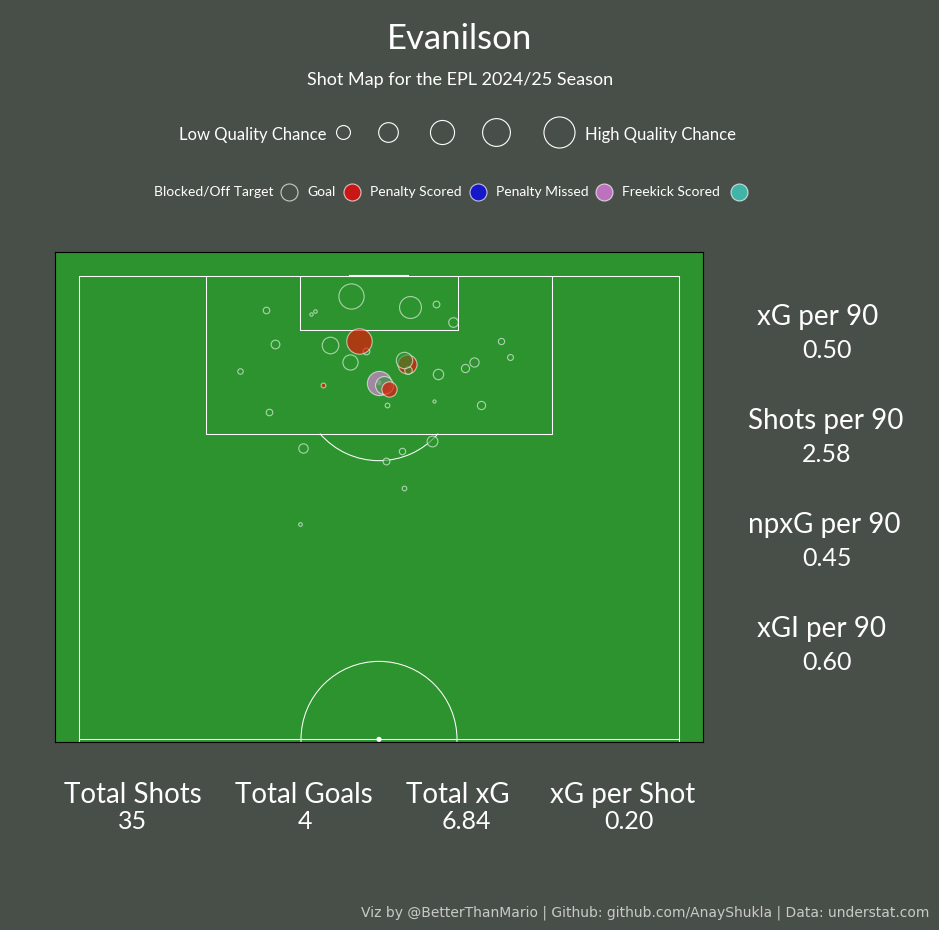

In [418]:
fig